In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift

In [663]:
%matplotlib widget
# makes plots interactive

In [735]:
%matplotlib inline

In [2]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [3]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [5]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [6]:
eta = f.get('eta')
eta = np.array(eta)

In [7]:
eta_flipped = np.transpose( np.flip(eta, axis= 2) , (1, 2, 0))
eta_flipped.shape

(67, 67, 1200)

In [8]:
eta = eta_flipped
eta.shape

(67, 67, 1200)

In [9]:
# new version with eta changed dimension 
def cylinder_cross_section(Spectrum, dtheta, power_Spectrum_cut , order=None):
    if order is None:
        order = 4

    Kx_2D = np.squeeze(Kx_3D[:,:,0])
    Ky_2D = np.squeeze(Ky_3D[:,:,0])
    W_1D = np.squeeze(W_3D[0,0,:])

    theta_2D = np.arctan2(-Ky_2D, -Kx_2D)
    theta_3D = np.tile(theta_2D[:, :, np.newaxis], (1, 1, W_1D.size))

    theta_vals = np.arange(-np.pi, np.pi, dtheta)
    S_cyl = np.zeros((W_1D.size, theta_vals.size))

    for ii in range(theta_vals.size):
        theta_diff = np.angle(np.exp(1j * theta_3D) * np.exp(-1j * theta_vals[ii]))
        theta_filt = np.exp(-2 * (theta_diff / dtheta) ** order)
        S_filt = power_Spectrum_cut * theta_filt
        S_cyl[:, ii] = np.nansum(S_filt, axis=(0, 1))

    thetaM, omegaM = np.meshgrid(theta_vals, W_1D)

    Scyl = {
        'P_k': S_cyl,
        'thetaM': thetaM,
        'omegaM': omegaM,
        'Kx_2D': Kx_2D, 
        'Ky_2D': Ky_2D,
        'W_1D': W_1D,
        'theta_2D':theta_2D,
        'theta_3D':theta_3D,
        'theta_vals':theta_vals,
        'theta_diff':theta_diff,
        'theta_filt':theta_filt
    }

    return Scyl

In [10]:
dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
dk

0.012503851357571316

In [11]:
frequencyLimits = [0.01,20.0]
# frequency limits for masking the spectrum [min max], rad/sec

In [12]:
Kx = spec3d.kx
Ky = spec3d.ky
w = spec3d.w

In [13]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [14]:
Norm = dKx * dKy * dW

In [15]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [16]:
power_Spectrum

array([[[0.0003803 , 0.00038039, 0.00037981, ..., 0.00038023,
         0.00038076, 0.00038051],
        [0.00038624, 0.00038567, 0.00038531, ..., 0.00038688,
         0.00038656, 0.00038527],
        [0.00039817, 0.00039769, 0.0003965 , ..., 0.00040039,
         0.00039836, 0.00039819],
        ...,
        [0.00039611, 0.00039523, 0.00039554, ..., 0.00039549,
         0.00039607, 0.00039608],
        [0.00038371, 0.00038475, 0.00038526, ..., 0.00038214,
         0.00038406, 0.00038371],
        [0.00037908, 0.00037975, 0.00037982, ..., 0.00038066,
         0.00037899, 0.00038024]],

       [[0.00039662, 0.00039677, 0.00039688, ..., 0.00039758,
         0.00039772, 0.00039724],
        [0.0004035 , 0.00040388, 0.00040219, ..., 0.00040498,
         0.0004043 , 0.00040389],
        [0.00041642, 0.00041672, 0.00041568, ..., 0.00041939,
         0.00041783, 0.00041654],
        ...,
        [0.00041015, 0.00041087, 0.00041003, ..., 0.00041099,
         0.00041064, 0.00041129],
        [0.0

# Try according to "An Algorithm for Surface Current Retrieval from X-band Marine Radar Images" Paper


In [17]:
power_Spectrum.shape

(67, 67, 1200)

# 2.2 Extracting the Dispersion Shell

## High Pass Filter

In [207]:
I_0 = power_Spectrum
I_0.shape

(67, 67, 1200)

In [208]:
w_cut = 0.03 * 2*np.pi

In [209]:
dx = 7.5 
dy = 7.5
dt = 1

In [210]:
# Kx = spec3d.kx
# Ky = spec3d.ky
# w = spec3d.w

Nx, Ny, Nt = eta.shape
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [211]:
# Create a boolean mask based on the condition w >= w_cut
mask = (w >= w_cut)

In [212]:
I_1 = np.where(mask[ None, None,:], I_0, 0)

## Energy Threshold Filter

In [213]:
# Create a boolean mask based on the condition energy

P = np.max(I_1) / 2000
# Threshold

condition = ( np.max(I_1, axis=2) >= P )
# Is  maximum energy for each column vector along the ω axis > P

In [214]:
I_2 = np.where(condition[:, :, None], I_1, 0)

In [215]:
I_2.shape

(67, 67, 1200)

## Peak Identification

In [216]:
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [217]:
def check_prominent_peaks(kx, ky):
    y = I_2[kx, ky,:]
    
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
        
    else:
        peak_heights = y
        
        # Find the peak with the maximum height
        max_peak_index = np.argmax(peak_heights)
        max_peak_height = peak_heights[max_peak_index]

        threshold = 6

        # Check if the maximum peak 6 times larger than the others
        # If it is we conclude it is a peak on its own and print
        if max_peak_height > threshold * np.max(peak_heights[peak_heights != max_peak_height]):
            wj[kx,ky] = w[max_peak_index]
            
        else:
            pass
            
    return wj

In [313]:
def identification(kx, ky, ratio=10., prominence=1e5, distance=25):
    
    '''Scans for peaks and then sorts them by heights. 
    It keeps the peaks which are ratio times smaller than the next'''
    
    y = I_2[kx,ky,:]
    wj = np.zeros((I_2.shape[0], I_2.shape[1]))
    
    if np.max(y) < 1:
        wj[kx, ky] = 0
    # If Power Spectrum is 0 then wj is 0
    
    else:
        peaks, stats = find_peaks(y, prominence=prominence, distance=distance)
        order = np.flip(np.argsort(stats["prominences"]))

        values = []

        if len(peaks) == 1:
            values.append(w[peaks[0]])
            wj[kx,ky] = w[peaks[0]]

        elif len(peaks) > 1:
            for i, j in zip(order[:-1], order[1:]):
                if stats["prominences"][i] >= ratio * stats["prominences"][j]:
                    values.append(w[peaks[i]])
                    wj[kx,ky] = w[peaks[i]]
                    
#        return {
#            "values": values,
#            "order": order,
#            "peaks": peaks,
#            "stats": stats,
#        }
    
    return wj 
    # rteurns 2d array wj 
    # it will al be 0 if there are no prominent peaks 
    # Otherwise it will have the w value of the singular prominent peak and the ret will be 0 

Text(0.5, 1.0, 'Should be counted')

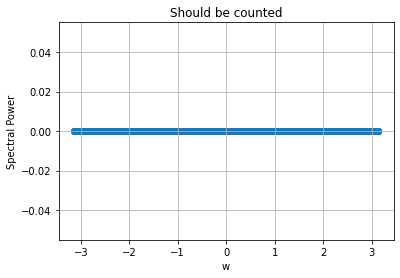

In [219]:
plt.scatter(w, I_2[40,43,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)
plt.title("Should be counted")

In [134]:
wj = identification(40, 53, ratio=10., prominence=1e5, distance=25)

In [135]:
np.min(wj)

-1.6650441064025905

Text(0.5, 1.0, 'Should be counted')

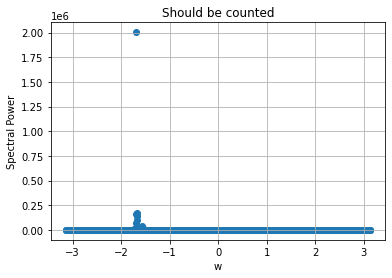

In [136]:
plt.scatter(w, I_2[14,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

plt.title("Should be counted")

In [137]:
wj = identification(14, 53, ratio=10., prominence=1e5, distance=25)

In [138]:
np.min(wj)

-1.6912240451825054

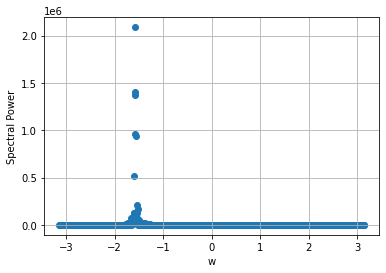

In [140]:
plt.scatter(w, I_2[22,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [141]:
wj = identification(22, 53, ratio=10., prominence=1e5, distance=25)

In [142]:
np.min(wj)

-1.5812683023068625

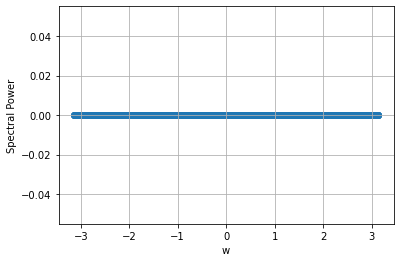

In [38]:
plt.scatter(w, I_2[10,53,:])

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [143]:
wj = identification(10, 53, ratio=10., prominence=1e5, distance=25)

In [145]:
np.max(wj)

0.0

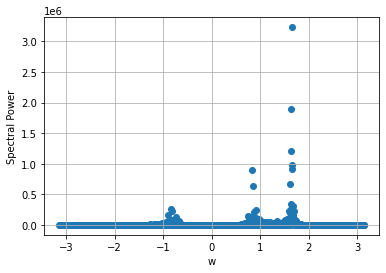

In [146]:
y = I_2[32,11,:]

plt.scatter(w, y)

plt.xlabel("w")
plt.ylabel("Spectral Power")
plt.grid(True)

In [147]:
wj = identification(32, 11, ratio=10., prominence=1e5, distance=25)

In [149]:
np.max(wj)

0.0

In [353]:
wj_array = []

for kx in range(I_2.shape[0]):
    for ky in range(I_2.shape[1]):
        wj_array.append(identification(kx, ky, ratio=10., prominence=1e5, distance=10))

In [354]:
wj_array

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

In [355]:
w0_2D = np.sum(wj_array, axis=0)
# gives the 2d array w0(kx,ky)

In [356]:
w0_2D.shape

(67, 67)

In [357]:
w0_2D.shape

(67, 67)

In [358]:
w0 = w0_2D[w0_2D != 0]

In [359]:
w0.shape

(521,)

In [360]:
nonzero_indices = np.nonzero(w0_2D)

In [361]:
nonzero_indices[0].shape

(521,)

In [362]:
kx_indices = nonzero_indices[0]
ky_indices = nonzero_indices[1]

In [363]:
kx_trip = Kx[kx_indices]
ky_trip = Ky[ky_indices]

In [376]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww, kk, th

In [782]:
%matplotlib widget

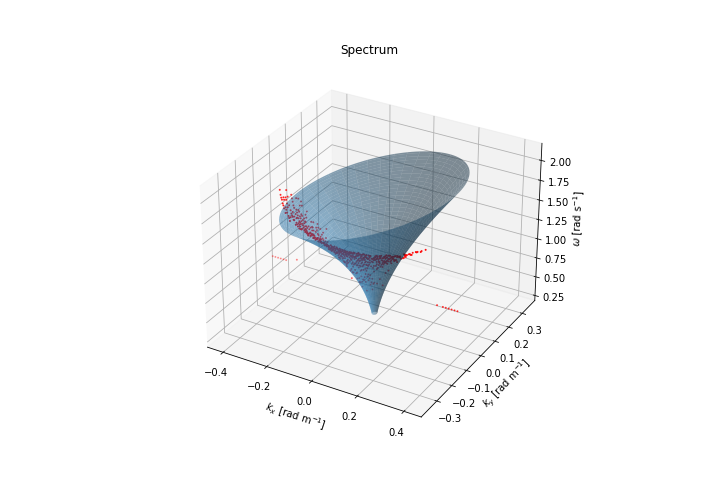

In [783]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_trip, ky_trip, w0, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0)
 
# show plot
plt.show()

In [393]:
# We now have a rough estimation of the dispersion shell using the power spectrum

# 2.3 Converting to the Polar Current Shell

In [395]:
kx_trip.shape

(521,)

In [396]:
ky_trip.shape

(521,)

In [398]:
w0.shape

(521,)

In [872]:
w0

array([0.84299403, 0.84299403, 0.84299403, 0.84299403, 0.84299403,
       0.84299403, 0.89011792, 2.00014732, 1.93731547, 1.9687314 ,
       1.86924763, 1.96349541, 1.94778745, 1.92684349, 1.91637152,
       1.85353967, 1.81688775, 1.79070781, 1.9687314 , 1.94778745,
       1.92684349, 1.84306769, 1.76452787, 1.95302343, 1.91113553,
       1.86924763, 1.82735973, 1.76452787, 1.74358392, 1.95825942,
       1.91637152, 1.89542757, 1.82735973, 1.78547182, 1.75929189,
       1.65980812, 1.95302343, 1.91637152, 1.86924763, 1.82735973,
       1.78023584, 1.76976386, 1.71740398, 1.67028009, 1.91113553,
       1.85877565, 1.81165176, 1.77499985, 1.74358392, 1.72787596,
       1.67551608, 1.66504411, 1.95825942, 1.86401164, 1.83259571,
       1.79070781, 1.76976386, 1.74881991, 1.70693201, 1.67028009,
       1.60221225, 1.57603231, 1.51320046, 1.93207948, 1.89542757,
       1.8797196 , 1.82735973, 1.76452787, 1.74358392, 1.69122405,
       1.57079633, 1.51843645, 1.4974925 , 1.46084058, 1.39800

In [841]:
def wU_function(kx, ky, w0):
    g = 9.81
    return w0 - np.sqrt( g * np.sqrt(kx**2 + ky**2) )

In [842]:
wU_cartesian = wU_function(kx_trip, ky_trip, w0)

In [843]:
%matplotlib widget

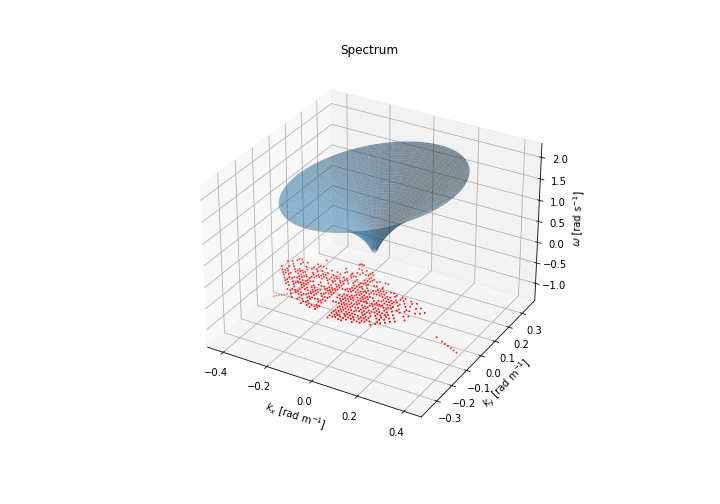

In [844]:
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(kx_trip, ky_trip, wU_cartesian, color = "red", s = 1)
plt.title("Spectrum")

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('η(x,y)')

kx, ky, ww, kk, th = plot_disp_shell(ax, h=1000, z=z, U=U, psi=0)
 
# show plot
plt.show()

In [845]:
k_polar = np.sqrt(kx_trip**2 + ky_trip**2)
theta_polar = np.arctan2(-ky_trip,-kx_trip) -np.pi/2
# Shifts by pi/2 so that theta is measured from kx=0

In [870]:
np.where(np.round(k_polar, 2) == 0.3)

(array([ 10,  15,  21,  39,  55,  66,  90, 121, 132, 146, 188, 208, 269,
        291, 329, 347, 364, 408, 449, 459, 472, 496, 501], dtype=int64),)

In [846]:
theta_polar

array([-1.39094283, -1.38544838, -1.37961187, -1.37340077, -1.36677835,
       -1.35970299, -1.32581766, -0.94200004, -1.03708814, -0.8902751 ,
       -1.05165021, -0.83798123, -0.86630226, -0.89605538, -0.92729522,
       -0.99442111, -1.06795312, -1.10714872, -0.78539816, -0.81241861,
       -0.84089667, -0.93576959, -1.0863184 , -0.7328151 , -0.78539816,
       -0.81396182, -0.87605805, -0.98279372, -1.02224692, -0.68052122,
       -0.70449406, -0.72989966, -0.81569192, -0.84781697, -0.88187194,
       -1.03907226, -0.62879629, -0.65107672, -0.69989287, -0.72664234,
       -0.78539816, -0.81764505, -0.85196633, -0.92729522, -0.59841889,
       -0.64350111, -0.69473828, -0.72297935, -0.75315128, -0.78539816,
       -0.81986726, -0.85670563, -0.52807445, -0.5880026 , -0.61072596,
       -0.63502674, -0.66104317, -0.68892439, -0.71883   , -0.75092906,
       -0.86217005, -0.90482709, -0.99945885, -0.49642275, -0.51445131,
       -0.53370819, -0.57637522, -0.60005021, -0.62548504, -0.68

In [795]:
wU_polar = wU_function(k_polar*np.cos(theta_polar), k_polar*np.sin(theta_polar), w0)

# 2.4 Determining Current Paramters

In [847]:
%matplotlib inline

In [848]:
k_polar.shape

(521,)

In [849]:
np.max(theta_polar)

1.3909428270024184

In [853]:
# Round the elements in theta_polar to 2 decimal places
rounded_theta = np.round(theta_polar, decimals=2)

# Find unique rounded values and their counts
unique_rounded, counts = np.unique(rounded_theta, return_counts=True)

# Filter values with counts greater than 4
selected_angles = unique_rounded[counts > 2]
selected_angles

array([-0.93, -0.82, -0.79, -0.73, -0.7 , -0.69, -0.66, -0.64, -0.63,
       -0.61, -0.59, -0.57, -0.53, -0.5 , -0.46, -0.44, -0.43, -0.4 ,
       -0.39, -0.38, -0.36, -0.35, -0.34, -0.32, -0.31, -0.29, -0.28,
       -0.27, -0.24, -0.23, -0.21, -0.2 , -0.19, -0.17, -0.15, -0.14,
       -0.12, -0.08,  0.  ,  0.11,  0.12,  0.14,  0.15,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.26,  0.27,  0.28,
        0.3 ,  0.31,  0.32,  0.34,  0.35,  0.36,  0.37,  0.38,  0.4 ,
        0.41,  0.42,  0.43,  0.44,  0.46,  0.48,  0.49,  0.5 ,  0.52,
        0.53,  0.56,  0.57,  0.59,  0.61,  0.63,  0.64,  0.66,  0.67,
        0.69,  0.71,  0.73,  0.75,  0.76,  0.79,  0.81,  0.82,  0.83,
        0.86,  0.93,  1.11])

##### Cut along an angle

In [854]:
cut_angle = 0

In [855]:
ind_cut = np.where(np.round(theta_polar, decimals=2) == 0)[0]

In [856]:
ind_cut

array([231, 232, 233, 234, 235, 236, 237, 238, 239, 240], dtype=int64)

In [857]:
x = np.arange(1, len(ind_cut)+1, 1)
x

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [864]:
wU_polar[ind_cut]/k_polar[ind_cut]

array([-0.07031169, -0.03447985,  0.00493183, -0.0017258 , -0.06812152,
        0.00581345, -0.0637794 , -0.077628  ,  0.42956205,  0.02314133])

Text(0, 0.5, '$\\frac{\\omega_{U}}{k}$')

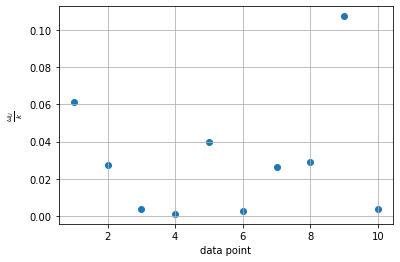

In [866]:
plt.scatter(x, np.abs( wU_polar[ind_cut]/0.3))
plt.grid(True)
plt.xlabel("data point")
plt.ylabel(r"$\frac{\omega_{U}}{k}$")

In [777]:
np.mean(  np.abs( wU_polar[ind_cut]/k_polar[ind_cut] )  )

0.07794949149148284

In [832]:
circumf = []

for i in range(len(selected_angles)):
    cut_angle = selected_angles[i]
    
    ind_cut = np.where(np.round(theta_polar, decimals=2) == cut_angle)[0]
    
    circumf.append( np.mean( np.abs(  (wU_polar[ind_cut])/k_polar[ind_cut] )  ) )
    
circumf = np.array([circumf])

In [833]:
circumf

array([[0.43518026, 0.42754828, 0.34689708, 0.38805689, 0.34659619,
        0.33914612, 0.29566569, 0.31406054, 0.34468652, 0.29305538,
        0.39621879, 0.25681463, 0.30116842, 0.26364726, 0.51111491,
        0.20953769, 0.14753174, 0.17369487, 0.21658629, 0.31661935,
        0.15287243, 0.15614563, 0.20440536, 0.09444807, 0.18468078,
        0.071158  , 0.12313202, 0.13900352, 0.40054784, 0.12317149,
        0.08163054, 0.26180311, 0.07644795, 0.14270001, 0.09108033,
        0.08117103, 0.0816944 , 0.05552959, 0.07794949, 0.08331889,
        0.05489502, 0.08456499, 0.09149354, 0.08199665, 0.05912138,
        0.09049861, 0.12931214, 0.10417775, 0.11282355, 0.11749295,
        0.11934825, 0.16108922, 0.14545864, 0.13552953, 0.19501622,
        0.16700473, 0.16442081, 0.20359343, 0.17120031, 0.2098969 ,
        0.20079578, 0.17626845, 0.18378921, 0.21428687, 0.28067903,
        0.18399472, 0.23036733, 0.23800512, 0.26617996, 0.22516196,
        0.30637814, 0.28775211, 0.28916563, 0.35

Text(0, 0.5, 'Current Shell')

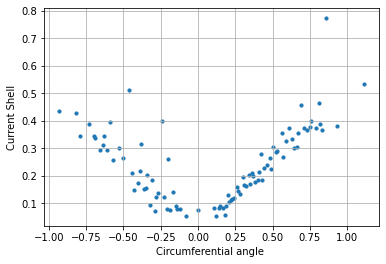

In [834]:
plt.scatter(selected_angles, circumf, s=10)
plt.grid(True)
plt.xlabel("Circumferential angle ")
plt.ylabel("Current Shell")

In [498]:
theta_polar.shape

(521,)

In [488]:
np.unique(theta_polar).shape

(388,)

In [425]:
from collections import Counter

In [426]:
element_counts = Counter(theta_polar)

# Find the most common element and its count
most_common_element, count = element_counts.most_common(1)[0]

In [427]:
most_common_element

-1.5707963267948966

In [428]:
count

10

### Cut along $\theta$ = -1.57 = $\frac{\pi}{2}$

In [443]:
inds = np.where(theta_polar == -1.5707963267948966)[0]
inds

array([231, 232, 233, 234, 235, 236, 237, 238, 239, 240], dtype=int64)

In [444]:
theta_polar[inds]

array([-1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633,
       -1.57079633, -1.57079633, -1.57079633, -1.57079633, -1.57079633])

In [449]:
wU_polar[inds] / k_polar[inds]

array([-0.07031169, -0.03447985,  0.00493183, -0.0017258 , -0.06812152,
        0.00581345, -0.0637794 , -0.077628  ,  0.42956205,  0.02314133])

In [451]:
inds-231

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

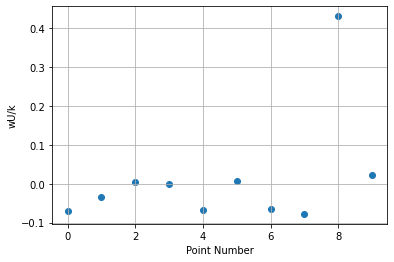

In [463]:
plt.scatter(inds - 231, wU_polar[inds] / k_polar[inds])

plt.xlabel("Point Number")
plt.ylabel("wU/k")
plt.grid(True)

In [458]:
np.sum(wU_polar[inds] / k_polar[inds])  / len(inds)

0.014740237950135914

In [461]:
( 0.07031169 + 0.03447985 +  0.00493183 + 0.0017258  + 0.06812152 + 0.0058134 + 0.0637794 + 0.077628  +  0.02314133)/10

0.034993282